100%|██████████| 9.91M/9.91M [00:00<00:00, 54.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.59MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.89MB/s]


🔹 Training Baseline Model...
Epoch 1/10 | Train Loss: 0.4362 | Val Loss: 0.2443 | Val Acc: 92.93%
Epoch 2/10 | Train Loss: 0.2187 | Val Loss: 0.1801 | Val Acc: 94.83%
Epoch 3/10 | Train Loss: 0.1617 | Val Loss: 0.1457 | Val Acc: 95.84%
Epoch 4/10 | Train Loss: 0.1283 | Val Loss: 0.1155 | Val Acc: 96.59%
Epoch 5/10 | Train Loss: 0.1063 | Val Loss: 0.1007 | Val Acc: 97.01%
Epoch 6/10 | Train Loss: 0.0909 | Val Loss: 0.0982 | Val Acc: 97.12%
Epoch 7/10 | Train Loss: 0.0793 | Val Loss: 0.0850 | Val Acc: 97.49%
Epoch 8/10 | Train Loss: 0.0693 | Val Loss: 0.0852 | Val Acc: 97.46%
Epoch 9/10 | Train Loss: 0.0624 | Val Loss: 0.0788 | Val Acc: 97.74%
Epoch 10/10 | Train Loss: 0.0558 | Val Loss: 0.0798 | Val Acc: 97.65%

🔸 Training Model with L2 Regularization...
Epoch 1/10 | Train Loss: 0.4398 | Val Loss: 0.2689 | Val Acc: 91.78%
Epoch 2/10 | Train Loss: 0.2228 | Val Loss: 0.1873 | Val Acc: 94.66%
Epoch 3/10 | Train Loss: 0.1658 | Val Loss: 0.1429 | Val Acc: 95.79%
Epoch 4/10 | Train Loss: 0.13

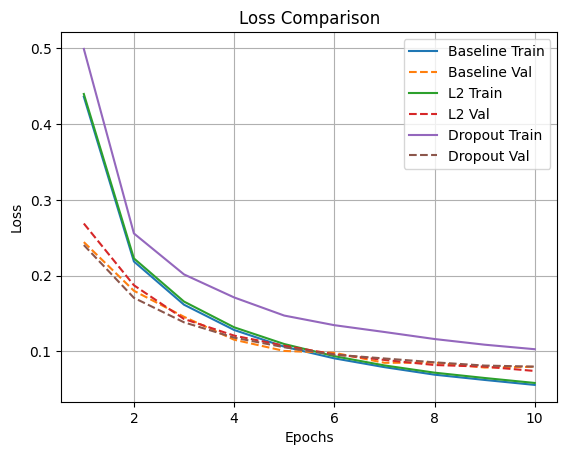

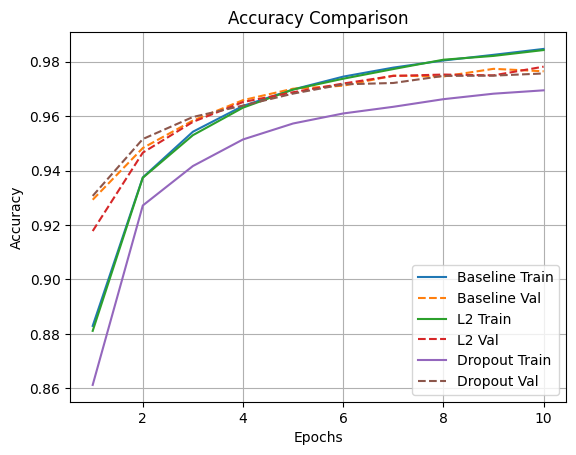

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 1️⃣ Load Data
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# 2️⃣ Define Model
class SimpleNN(nn.Module):
    def __init__(self, dropout=False):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.dropout = nn.Dropout(0.5) if dropout else nn.Identity()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# 3️⃣ Train + Evaluate Function
def train_and_evaluate(model, optimizer, criterion, epochs=10):
    train_losses, val_losses = [], []
    train_acc, val_acc = [], []

    for epoch in range(epochs):
        model.train()
        correct = 0
        loss_total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            loss_total += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_losses.append(loss_total / len(train_loader))
        train_acc.append(correct / len(train_loader.dataset))

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0

        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_losses.append(val_loss / len(test_loader))
        val_acc.append(val_correct / len(test_loader.dataset))

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]*100:.2f}%")

    return train_losses, val_losses, train_acc, val_acc

# 4️⃣ Train Three Models
results = {}

print("🔹 Training Baseline Model...")
model = SimpleNN()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
results["Baseline"] = train_and_evaluate(model, optimizer, criterion)

print("\n🔸 Training Model with L2 Regularization...")
model_l2 = SimpleNN()
optimizer_l2 = optim.SGD(model_l2.parameters(), lr=0.1, weight_decay=1e-4)
results["L2"] = train_and_evaluate(model_l2, optimizer_l2, criterion)

print("\n🔻 Training Model with Dropout...")
model_dropout = SimpleNN(dropout=True)
optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=0.1)
results["Dropout"] = train_and_evaluate(model_dropout, optimizer_dropout, criterion)

# 5️⃣ Plot Results
epochs = range(1, 11)

def plot_metric(index, title, ylabel):
    plt.figure()
    for lbl, (tl, vl, ta, va) in results.items():
        train = tl if index == 0 else ta
        val = vl if index == 0 else va
        plt.plot(epochs, train, label=f"{lbl} Train")
        plt.plot(epochs, val, label=f"{lbl} Val", linestyle='--')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

plot_metric(0, "Loss Comparison", "Loss")
plot_metric(1, "Accuracy Comparison", "Accuracy")
